# Machine Learning - Regression Models to Predict Sales 

In [1]:
# The aim of this section is to use Regression Models to predict the next year's sales of a company

# The models Linear Regression, Linear Regression with Elastic Net, and Random Forest Regressor are implemented. 

# The MSE and R-Square are used to measure and compare the performance of these models

# 0. Data Preparation

## 0. Data Preprocessing

In [53]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [54]:
# Read CSV file 
df = pd.read_csv(r"C:\Users\natti\OneDrive\Desktop\DS\ML\supervised learning\Project - Assignment1\VF\data_assignment_1.csv")

In [55]:
# Check data type of each column
print(df.dtypes)

Unnamed: 0      int64
id              int64
year            int64
yearest       float64
industry      float64
pertot        float64
enggrad       float64
sales         float64
va            float64
gom           float64
rdint         float64
reext         float64
ipnc          float64
ipnf          float64
ipnm          float64
ipr           float64
patent        float64
dtype: object


In [56]:
print(df.head())

   Unnamed: 0  id  year  yearest  industry  pertot  enggrad       sales  \
0           1   1  1990   1971.0      12.0   297.0      1.3  13582874.0   
1           2   1  1991   1971.0       NaN     NaN      1.3         NaN   
2           3   1  1992   1971.0       NaN     NaN      1.3         NaN   
3           4   1  1993   1971.0       NaN     NaN      1.3         NaN   
4           5   1  1994   1971.0      12.0   366.0      2.7  37156107.0   

          va   gom     rdint  reext  ipnc  ipnf  ipnm  ipr  patent  
0  7398459.0  14.3  216364.4    0.0   NaN   NaN   NaN  1.0     0.0  
1        NaN   NaN       NaN    NaN   NaN   NaN   NaN  NaN     NaN  
2        NaN   NaN       NaN    NaN   NaN   NaN   NaN  NaN     NaN  
3        NaN   NaN       NaN    NaN   NaN   NaN   NaN  NaN     NaN  
4  9943859.0   6.1  480809.7    0.0   0.0   0.0   0.0  1.0     0.0  


In [57]:
# Iterative Imputation 

# Specify the columns to impute
columns_to_impute = ['va', 'rdint', 'reext']

# Initialize the IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit and transform the imputer on the specified columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [58]:
# Find the minimum yearest (year established) value for each company
min_yearest = df.groupby('id')['yearest'].min().reset_index()

In [59]:
# Merge the minimum yearest back into the main dataframe based on 'id'
df = df.merge(min_yearest, on='id', suffixes=('', '_min'))

# Fill the 'yearest' column with the minimum year for each company
df['yearest'] = df['yearest_min']

In [60]:
# Linearly interpolate the 'sales' column
df['sales'] = df.groupby('id')['sales'].apply(lambda x: x.interpolate().bfill().ffill())

C:\Users\natti\AppData\Local\Temp\ipykernel_18468\3238646972.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['sales'] = df.groupby('id')['sales'].apply(lambda x: x.interpolate().bfill().ffill())


In [61]:
# Columns to exclude from the zero replacement
exclude_columns = ['id', 'year', 'industry', 'pertot', 'enggrad', 'gom']
# Impute missing values for columns in the exclude list
for col in exclude_columns:
    df[col] = df.groupby('id')[col].apply(lambda x: x.ffill().bfill())

C:\Users\natti\AppData\Local\Temp\ipykernel_18468\2575587288.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[col] = df.groupby('id')[col].apply(lambda x: x.ffill().bfill())
C:\Users\natti\AppData\Local\Temp\ipykernel_18468\2575587288.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[

In [62]:
# Find columns with NaN values that are not in the exclude list
nan_columns = df.columns[df.isna().any()].tolist()

In [63]:
# Exclude columns that are not part of the imputation process
nan_columns = [col for col in nan_columns if col not in columns_to_impute]

In [64]:
# Replace NaN values with zeros only in columns that are not excluded
df[nan_columns] = df[nan_columns].fillna(0)

In [65]:
# Drop the first column (running number column) as it might introduce noise in Linear Regression
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('yearest_min', axis=1)

In [66]:
# Add column to calculate High Growth Rate (10 percentile

df['Growth_Rate'] = df.groupby('id')['sales'].pct_change() * 100
#Drop all the values belonging to 1990 because the have a NA growth rate
df = df[df['year']!=1990]

# Calculate the 10th percentile of the 'Value' column
percentile_10 = np.percentile(df['Growth_Rate'], 10)

# Create a new column 'HGF' with values 1 if 'Value' is greater than or equal to the 10th percentile, else 0
df['HGF'] = (df['Growth_Rate'] >= percentile_10).astype(int)
## if the growth rate in sales of the company is above the 10% percentile the company is HGF (=1) else (=0)

In [67]:
# There are about 4% of missing values in the new column HGF. I decided to drop the value

# Drop the missing values
df = df.dropna()

In [68]:
# Create an empty DataFrame to store the missing percentage information
missing_info = pd.DataFrame(columns=['Column Name', 'Missing Percentage'])

# Calculate the missing percentage for each column and store it in the DataFrame
for column in df.columns:
    missing_percentage = (df[column].isnull().sum() / len(df)) * 100
    missing_info = missing_info.append({'Column Name': column, 'Missing Percentage': missing_percentage}, ignore_index=True)

# Sort the DataFrame by missing percentage (descending order)
missing_info = missing_info.sort_values(by='Missing Percentage', ascending=False)

# Print the missing information
print(missing_info)

    Column Name  Missing Percentage
0            id                 0.0
1          year                 0.0
16  Growth_Rate                 0.0
15       patent                 0.0
14          ipr                 0.0
13         ipnm                 0.0
12         ipnf                 0.0
11         ipnc                 0.0
10        reext                 0.0
9         rdint                 0.0
8           gom                 0.0
7            va                 0.0
6         sales                 0.0
5       enggrad                 0.0
4        pertot                 0.0
3      industry                 0.0
2       yearest                 0.0
17          HGF                 0.0


C:\Users\natti\AppData\Local\Temp\ipykernel_18468\1140047198.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missing_info = missing_info.append({'Column Name': column, 'Missing Percentage': missing_percentage}, ignore_index=True)
C:\Users\natti\AppData\Local\Temp\ipykernel_18468\1140047198.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missing_info = missing_info.append({'Column Name': column, 'Missing Percentage': missing_percentage}, ignore_index=True)
C:\Users\natti\AppData\Local\Temp\ipykernel_18468\1140047198.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missing_info = missing_info.append({'Column Name': column, 'Missing Percentage': missing_percentage}, ignore_index=True)
C:\Users\natti\AppData\Local\Te

## 0. Split Training and Testing Dataset

In [91]:
# The dataset contains the year of operation from 1990 - 2012 
# To ensure rationality of the outcome. I was assigned to use the dataset of year 2012 as test dataset

# Extract rows for training (years before 2012)
train_df = df[df['year'] < 2012]

from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
train_df, validation_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Extract rows for testing (year 2012)
test_df = df[df['year'] == 2012]

# Display the shape of training and testing sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", validation_df.shape)
print("Testing data shape:", test_df.shape)

Training data shape: (100018, 18)
Validation data shape: (11114, 18)
Testing data shape: (5292, 18)


In [92]:
print(train_df.head())

          id  year  yearest  industry  pertot  enggrad       sales  \
43725   1902  1992   1958.0      14.0    37.0      2.2   2759403.0   
16735    728  2004   1966.0      11.0     9.0      0.0    595068.0   
119544  5198  2003      0.0       9.0   188.0      4.8  16758236.0   
9051     394  2002   1964.0      20.0   472.0      1.7  48331430.0   
111900  4866  1995      0.0       2.0    52.0      7.7  13841816.0   

                  va   gom          rdint          reext  ipnc  ipnf  ipnm  \
43725   1.582819e+06  22.0       0.000000       0.000000   0.0   0.0   0.0   
16735   2.829906e+07  14.8  428660.335272  288497.607754   0.0   0.0   0.0   
119544  2.829906e+07   9.0  428660.335272  288497.607754   0.0   0.0   0.0   
9051    2.526530e+07  15.8  129286.000000       0.000000   0.0   0.0   0.0   
111900  2.829906e+07  12.1  428660.335272  288497.607754   0.0   0.0   0.0   

        ipr  patent  Growth_Rate  HGF  
43725   0.0     0.0   -29.413331    0  
16735   0.0     0.0     0.0000

## 0. Data Exploration

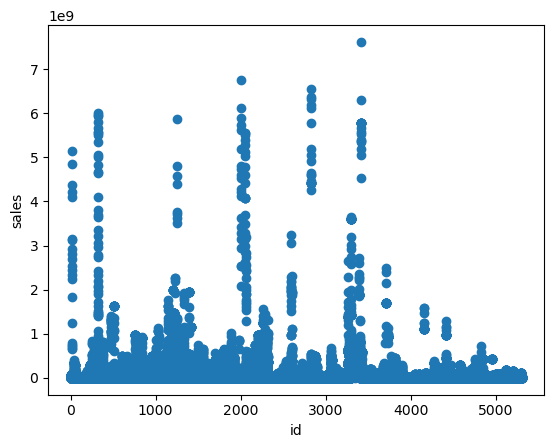

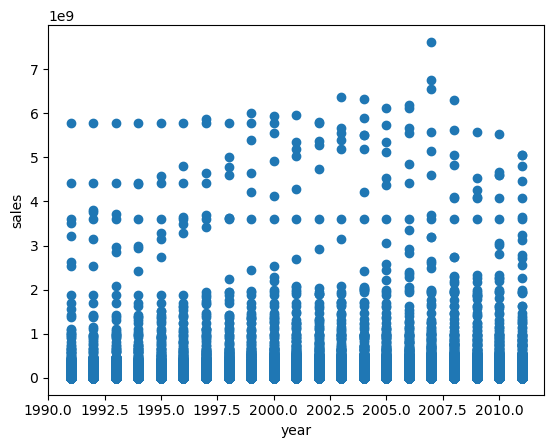

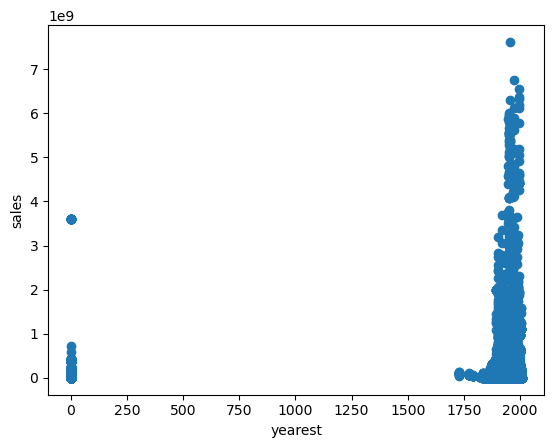

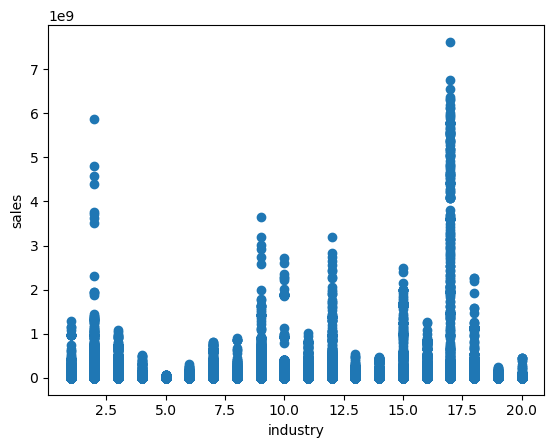

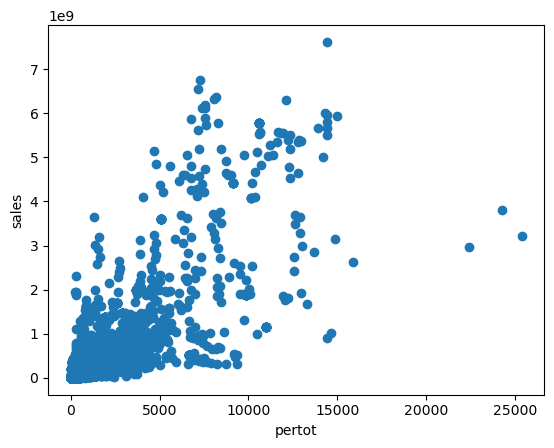

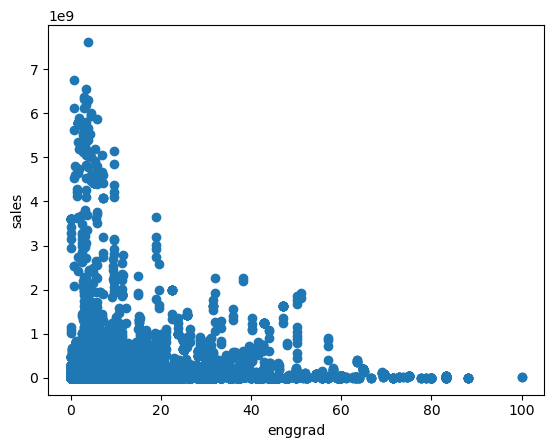

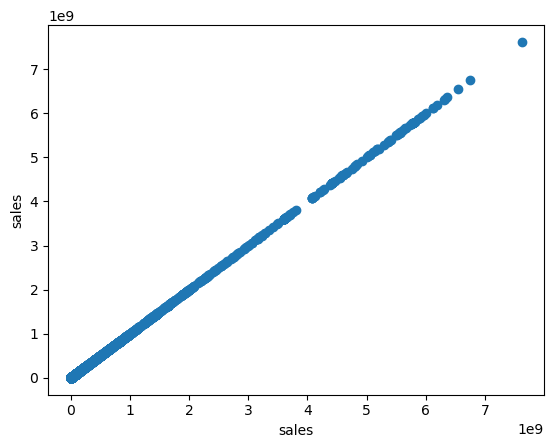

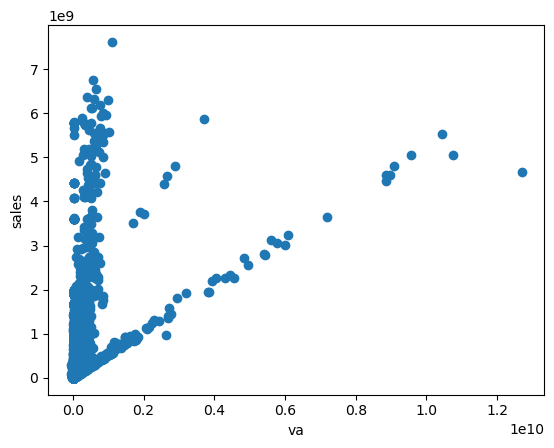

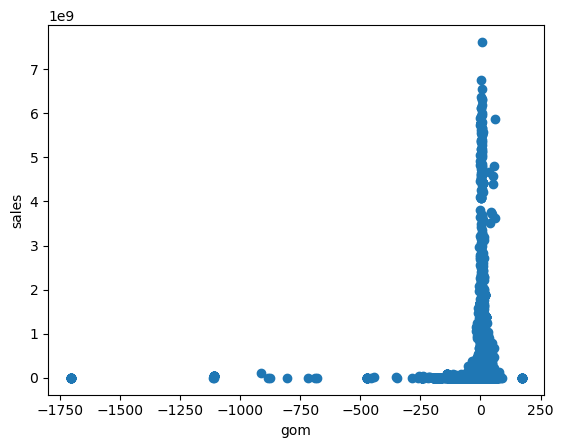

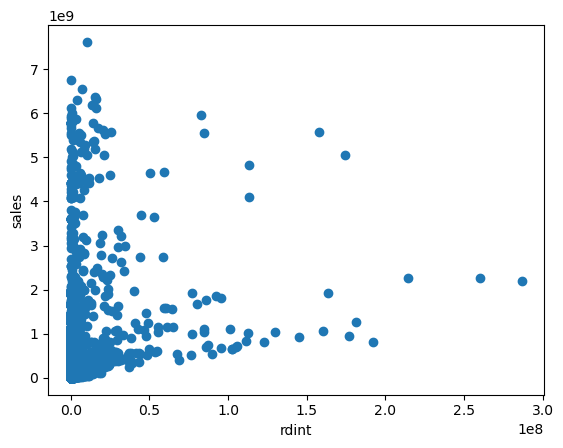

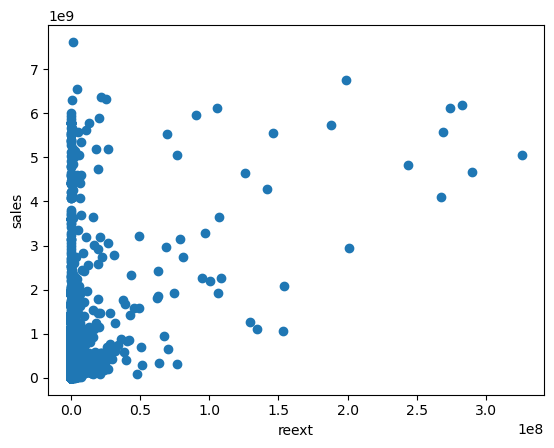

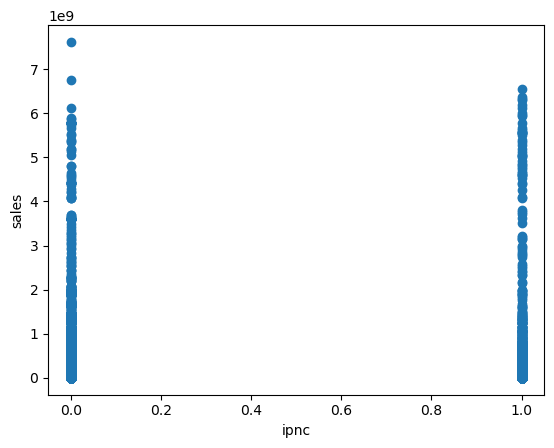

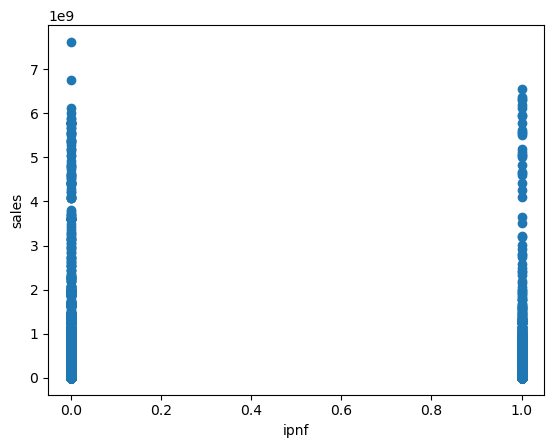

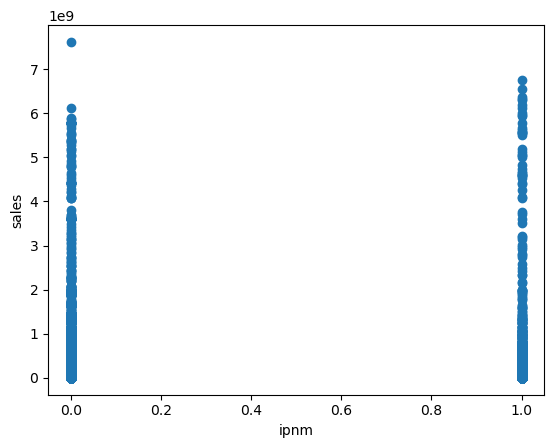

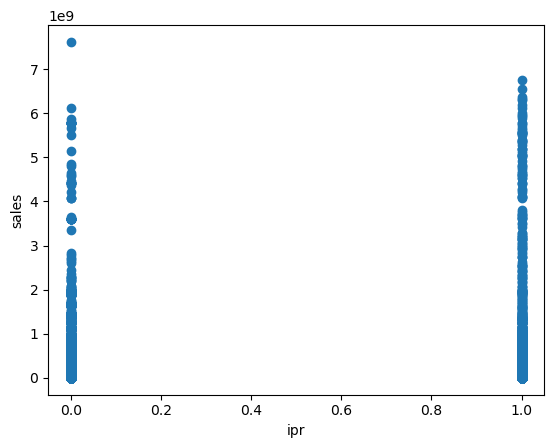

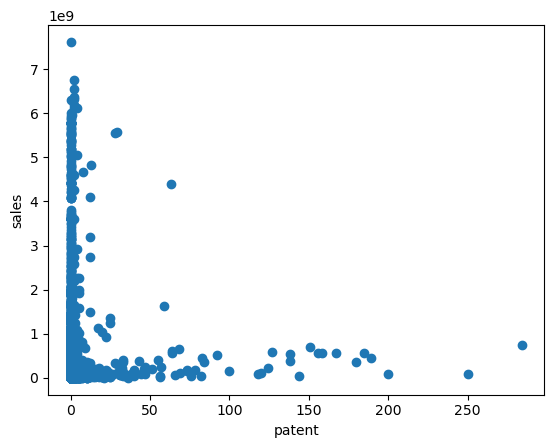

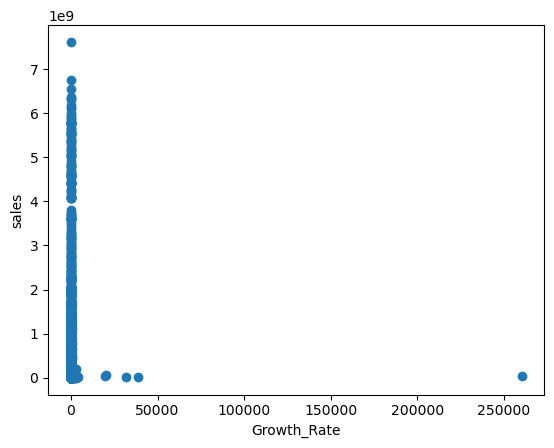

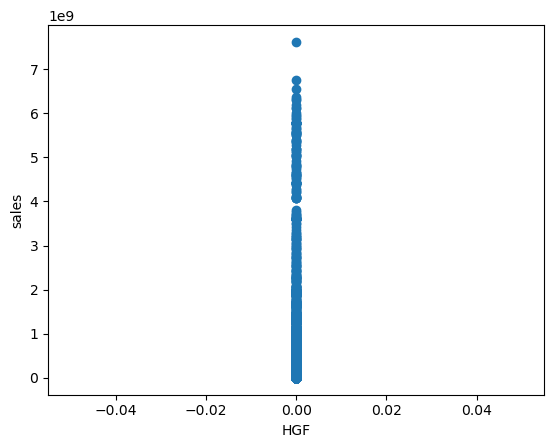

In [86]:
#Plot to see general behaviour on how the parameters impact sales
for label in train_df[1:]:
    plt.scatter(train_df[label], train_df['sales'])
    plt.ylabel('sales')
    plt.xlabel(label)
    plt.show()

# 1. Regression Models

## 1.1 Linear Regression

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [94]:
#After analysing the plots in 0. Data Exploration, I decided to drop some parameters that do not impact on 'sales'
columns_to_drop = ['id', 'year', 'yearest', 'industry', 'gom', 'ipnc', 'ipnf', 'ipnm', 'ipr', 'Growth_Rate', 'HGF']
train_df.drop(columns=columns_to_drop, inplace=True)
validation_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

C:\Users\natti\AppData\Local\Temp\ipykernel_18468\3905997099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=columns_to_drop, inplace=True)


In [95]:
#Standardized the data to have all the columns with the same scales

def preprocessor(train_df, test_df, validation_df):
    # List of columns used for fitting the scaler
    scaler_columns = ['pertot', 'enggrad', 'sales', 'va', 'rdint', 'reext', 'patent']
    
    # Initialize StandardScaler and fit it to the training data
    scaler = StandardScaler().fit(train_df[scaler_columns])
    
    # Standardize selected columns for both training and testing data
    train_df[scaler_columns] = scaler.transform(train_df[scaler_columns])
    validation_df[scaler_columns] = scaler.transform(validation_df[scaler_columns])
    test_df[scaler_columns] = scaler.transform(test_df[scaler_columns])
    
    return train_df, test_df, validation_df

train_df_preprocessed, test_df_preprocessed, validation_df_preprocessed = preprocessor(train_df,test_df,validation_df)

C:\Users\natti\AppData\Local\Temp\ipykernel_18468\3428016652.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[scaler_columns] = scaler.transform(test_df[scaler_columns])


In [96]:
# Features and target variable for training set
X_train = train_df_preprocessed.drop("sales", axis=1)  # Features (exclude "sales" column)
y_train = train_df_preprocessed["sales"]  # Target variable

# Features and target variable for validation set
X_val = validation_df_preprocessed.drop("sales", axis=1)  # Features (exclude "sales" column) for validation
y_val = validation_df_preprocessed["sales"]  # Actual sales values for validation

# Features and target variable for testing set
X_test = test_df_preprocessed.drop("sales", axis=1)  # Features (exclude "sales" column) for testing
y_test = test_df_preprocessed["sales"]  # Actual sales values for testing

In [98]:
# Fit LR model 
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [99]:
# Make prediction 

y_lr_train_pred = lr.predict(X_train)
y_lr_val_pred = lr.predict(X_val)
y_lr_test_pred = lr.predict(X_test)

In [102]:
# Evaluate model performance (Training dataset)
lr_train_MSE = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

In [103]:
# Evaluate model performance (Validation dataset)
lr_val_MSE = mean_squared_error(y_val, y_lr_val_pred)
lr_val_r2 = r2_score(y_val, y_lr_val_pred)

In [104]:
# Evaluate model performance (Testing dataset)
lr_test_MSE = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [105]:
# Print or display the results
print("Train MSE:", lr_train_MSE)
print("Train R^2:", lr_train_r2)

print("Validation MSE:", lr_val_MSE)
print("Validation R^2:", lr_val_r2)

print("Test MSE:", lr_test_MSE)
print("Test R^2:", lr_test_r2)

Train MSE: 0.3010807002593802
Train R^2: 0.6989192997406198
Validation MSE: 0.32902770389448527
Validation R^2: 0.6767930820797154
Test MSE: 0.22751495141018113
Test R^2: 0.7876552714196317


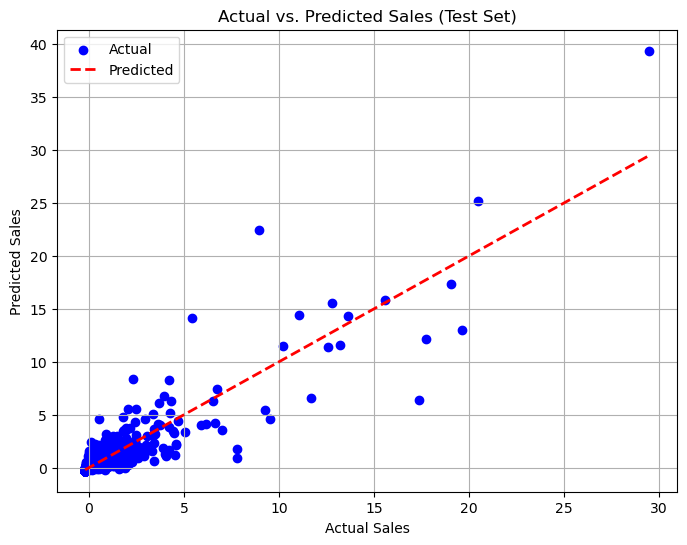

In [106]:
# Plot actual vs. predicted values for test set
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_lr_test_pred, color='blue', label='Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Predicted')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs. Predicted Sales (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

## 1.2 Elastic Net

In [127]:
# Using ElasticNet to improve performanace of LR model

from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.2, l1_ratio=0.4)

In [128]:
#Train the data
elastic_net.fit(X_train, y_train)

ElasticNet(alpha=0.2, l1_ratio=0.4)

In [129]:
#Make prediction
y_lr_train_pred = elastic_net.predict(X_train)
y_lr_val_pred = elastic_net.predict(X_val)
y_lr_test_pred = elastic_net.predict(X_test)

In [130]:
#Evaluate model performance
lr_train_MSE = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

# Calculate evaluation metrics for validation set
lr_val_MSE = mean_squared_error(y_val, y_lr_val_pred)
lr_val_r2 = r2_score(y_val, y_lr_val_pred)

lr_test_MSE = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [131]:
#Results
print("Train MSE:", lr_train_MSE)
print("Train R^2:", lr_train_r2)

print("Validation MSE:", lr_val_MSE)
print("Validation R^2:", lr_val_r2)

print("Test MSE:", lr_test_MSE)
print("Test R^2:", lr_test_r2)

Train MSE: 0.33550323711345664
Train R^2: 0.6644967628865435
Validation MSE: 0.3505437997403927
Validation R^2: 0.6556576246646666
Test MSE: 0.21012008134515575
Test R^2: 0.8038902877987939


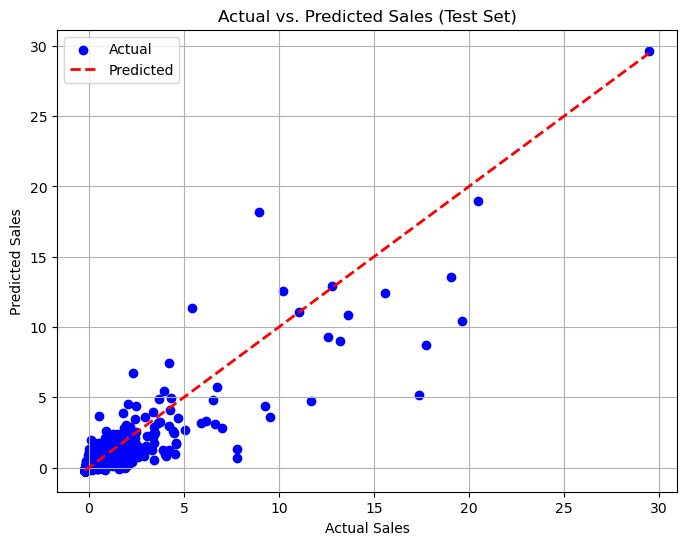

In [132]:
# Plot actual vs. predicted values for test set
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_lr_test_pred, color='blue', label='Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Predicted')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs. Predicted Sales (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

## 1.3 Random Forest Regressor 

In [133]:
from sklearn.ensemble import RandomForestRegressor  # for regression

In [134]:
# Create a Random Forest Regressor for training set
rf_regressor_train = RandomForestRegressor(n_estimators=100, random_state=42)

In [135]:
# Train the model with the entire training dataset
rf_regressor_train.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [136]:
#Make prediction of training dataset
y_pred_train = rf_regressor_train.predict(X_train)

In [137]:
# Create a Random Forest Regressor for training set
rf_regressor_validation = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_validation.fit(X_train, y_train)
y_pred_validation = rf_regressor_validation.predict(X_val)

In [138]:
# Create a Random Forest Regressor for test set
rf_regressor_test = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_test.fit(X_train, y_train)  # Note that you're using the same X_train and y_train for both training and test set
y_pred_test = rf_regressor_test.predict(X_test)

In [139]:
# Evaluate the models
mse_rf_train = mean_squared_error(y_train, y_pred_train)
r2_rf_train = r2_score(y_train, y_pred_train)

mse_rf_validation = mean_squared_error(y_val, y_pred_validation)
r2_rf_val = r2_score(y_val, y_pred_validation)

mse_rf_test = mean_squared_error(y_test, y_pred_test)
r2_rf_test = r2_score(y_test, y_pred_test)

In [140]:
# Print or display the results
print("Train MSE:", mse_rf_train)
print("Train R^2:", r2_rf_train)

print("Validation MSE:", mse_rf_validation)
print("Validation R^2:", r2_rf_val)

print("Test MSE:",mse_rf_test)
print("Test R^2:", r2_rf_test)

Train MSE: 0.012051757827622689
Train R^2: 0.9879482421723773
Validation MSE: 0.06724575538210852
Validation R^2: 0.9339438804604655
Test MSE: 0.05399508872206292
Test R^2: 0.9496051912707558
